### Import lib

In [31]:
import os
import numpy as np
import sys
import pandas as pd
import xarray as xr
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
import joblib
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
from matplotlib import colors
from matplotlib import ticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cmcrameri import cm

from treeconfigparser import TreeConfigParser

os.chdir("/cerea_raid/users/dumontj/dev/coco2/dl")
import models.reg as rg
import models.seg as sg
from data.Data import Data
from include.loss import rmae
from include import generators

import matplotlib_functions
matplotlib_functions.setMatplotlibParam()
plt.viridis()

import ddeq_cosmo.build_ds as build_ds
from ddeq_cosmo.ddeq_eval import get_mean_loss, shift_to_proba, get_all_loss
from scipy.optimize import differential_evolution
dir_res = "/cerea_raid/users/dumontj/dev/coco2/dl/res"
dir_plots = "/cerea_raid/users/dumontj/dev/coco2/dl/eval/reg"
dir_eval_ddeq = "/libre/dumontj/coco2/ddeq/eval"

<Figure size 1800x1200 with 0 Axes>

In [33]:
def get_data(name_ds: str, scaler, mode: str):
    config = TreeConfigParser()
    config.readfiles(os.path.join(dir_res, name_ds, "config.cfg"))
    with open(os.path.join(dir_res, name_ds, "tv_inds.pkl"), "rb") as handle:
        tv_inds = pickle.load(handle)
    data = Data(config, tv_inds, mode)
    data.prepare_input(scaler)
    data.prepare_output()
    return data

def get_data_name(weights: str):
    config_weights = TreeConfigParser()
    config_weights.readfiles(os.path.join(dir_res, weights, "config.cfg"))
    weights_ds = config_weights.get("data.directory.name")
    return weights_ds

def get_model(path_w: str):
    model = keras.models.load_model(os.path.join(path_w, "weights_cp_best.h5"),
                                    custom_objects={"relative_mae": rmae, "rmae": rmae},
                                    compile=True)
    return model

def get_scaler(path_w: str):
    scaler = joblib.load(os.path.join(path_w, "scaler.save"))
    return scaler

mode = "train"

## Berlin on Berlin

In [34]:
case = "2km_reg_ber_seg_8_no2"
dataset = case
weights = case

In [35]:
model = get_model(os.path.join(dir_res, weights))
scaler = get_scaler(os.path.join(dir_res, weights))
data = get_data(os.path.join(dir_res, dataset), scaler, mode=mode)

data.x.train.shape (6577, 96, 96, 3)
data.y.train.shape (6577, 1)


In [36]:
x_valid = tf.convert_to_tensor(data.x.valid, np.float32)
pred_valid = tf.convert_to_tensor(model.predict(x_valid), np.float32)
y_valid = tf.convert_to_tensor(data.y.valid, np.float32)
ds = xr.open_dataset(data.path_dataset)
ds_valid = ds.sel(idx_img=data.eval_shuffler.ds_inds["valid"])

msle = tf.keras.losses.MeanSquaredLogarithmicError(reduction=tf.keras.losses.Reduction.NONE,)
rae = tf.keras.losses.MeanAbsolutePercentageError(reduction=tf.keras.losses.Reduction.NONE,)

all_loss_valid = msle(y_valid, pred_valid)
all_rae_valid = rae(y_valid, pred_valid)
print("CNN, mean msle:", np.mean(all_loss_valid))
print("CNN, median msle:", np.median(all_loss_valid))
print("CNN, rmae", np.mean(all_rae_valid.numpy()))
print("CNN, median_rae", np.median(all_rae_valid.numpy()))

CNN, mean msle: 0.13664204
CNN, median msle: 0.06551185
CNN, rmae 36.670902
CNN, median_rae 26.856873


#### Baseline

In [37]:
mean_valid = tf.math.reduce_mean(y_valid) * tf.ones_like(y_valid, np.float32)
all_loss_baseline = msle(y_valid, mean_valid)
all_rae_baseline = rae(y_valid, mean_valid)
print("baseline, mean msle:", np.mean(all_loss_baseline))
print("baseline, median msle:", np.median(all_loss_baseline))
print("baseline, rmae", np.mean(all_rae_baseline.numpy()))
print("baseline, median_rae", np.median(all_rae_baseline.numpy()))

baseline, mean msle: 0.17910004
baseline, median msle: 0.09655258
baseline, rmae 44.276566
baseline, median_rae 33.167328


### Random output

In [44]:
def choose_index():
    idx = int(np.random.uniform(0,data.y.valid.shape[0]))
    print("loss", all_loss_valid[idx].numpy(), "rae", all_rae_valid[idx].numpy())
    return idx

In [100]:
idx0 = choose_index()
idx1 = choose_index()
idx2 = choose_index()
idx3 = choose_index()

loss 0.1262572 rae 30.994114
loss 0.016654091 rae 12.726639
loss 0.33715758 rae 90.328285
loss 0.21817476 rae 38.61958


<Figure size 1800x1200 with 0 Axes>

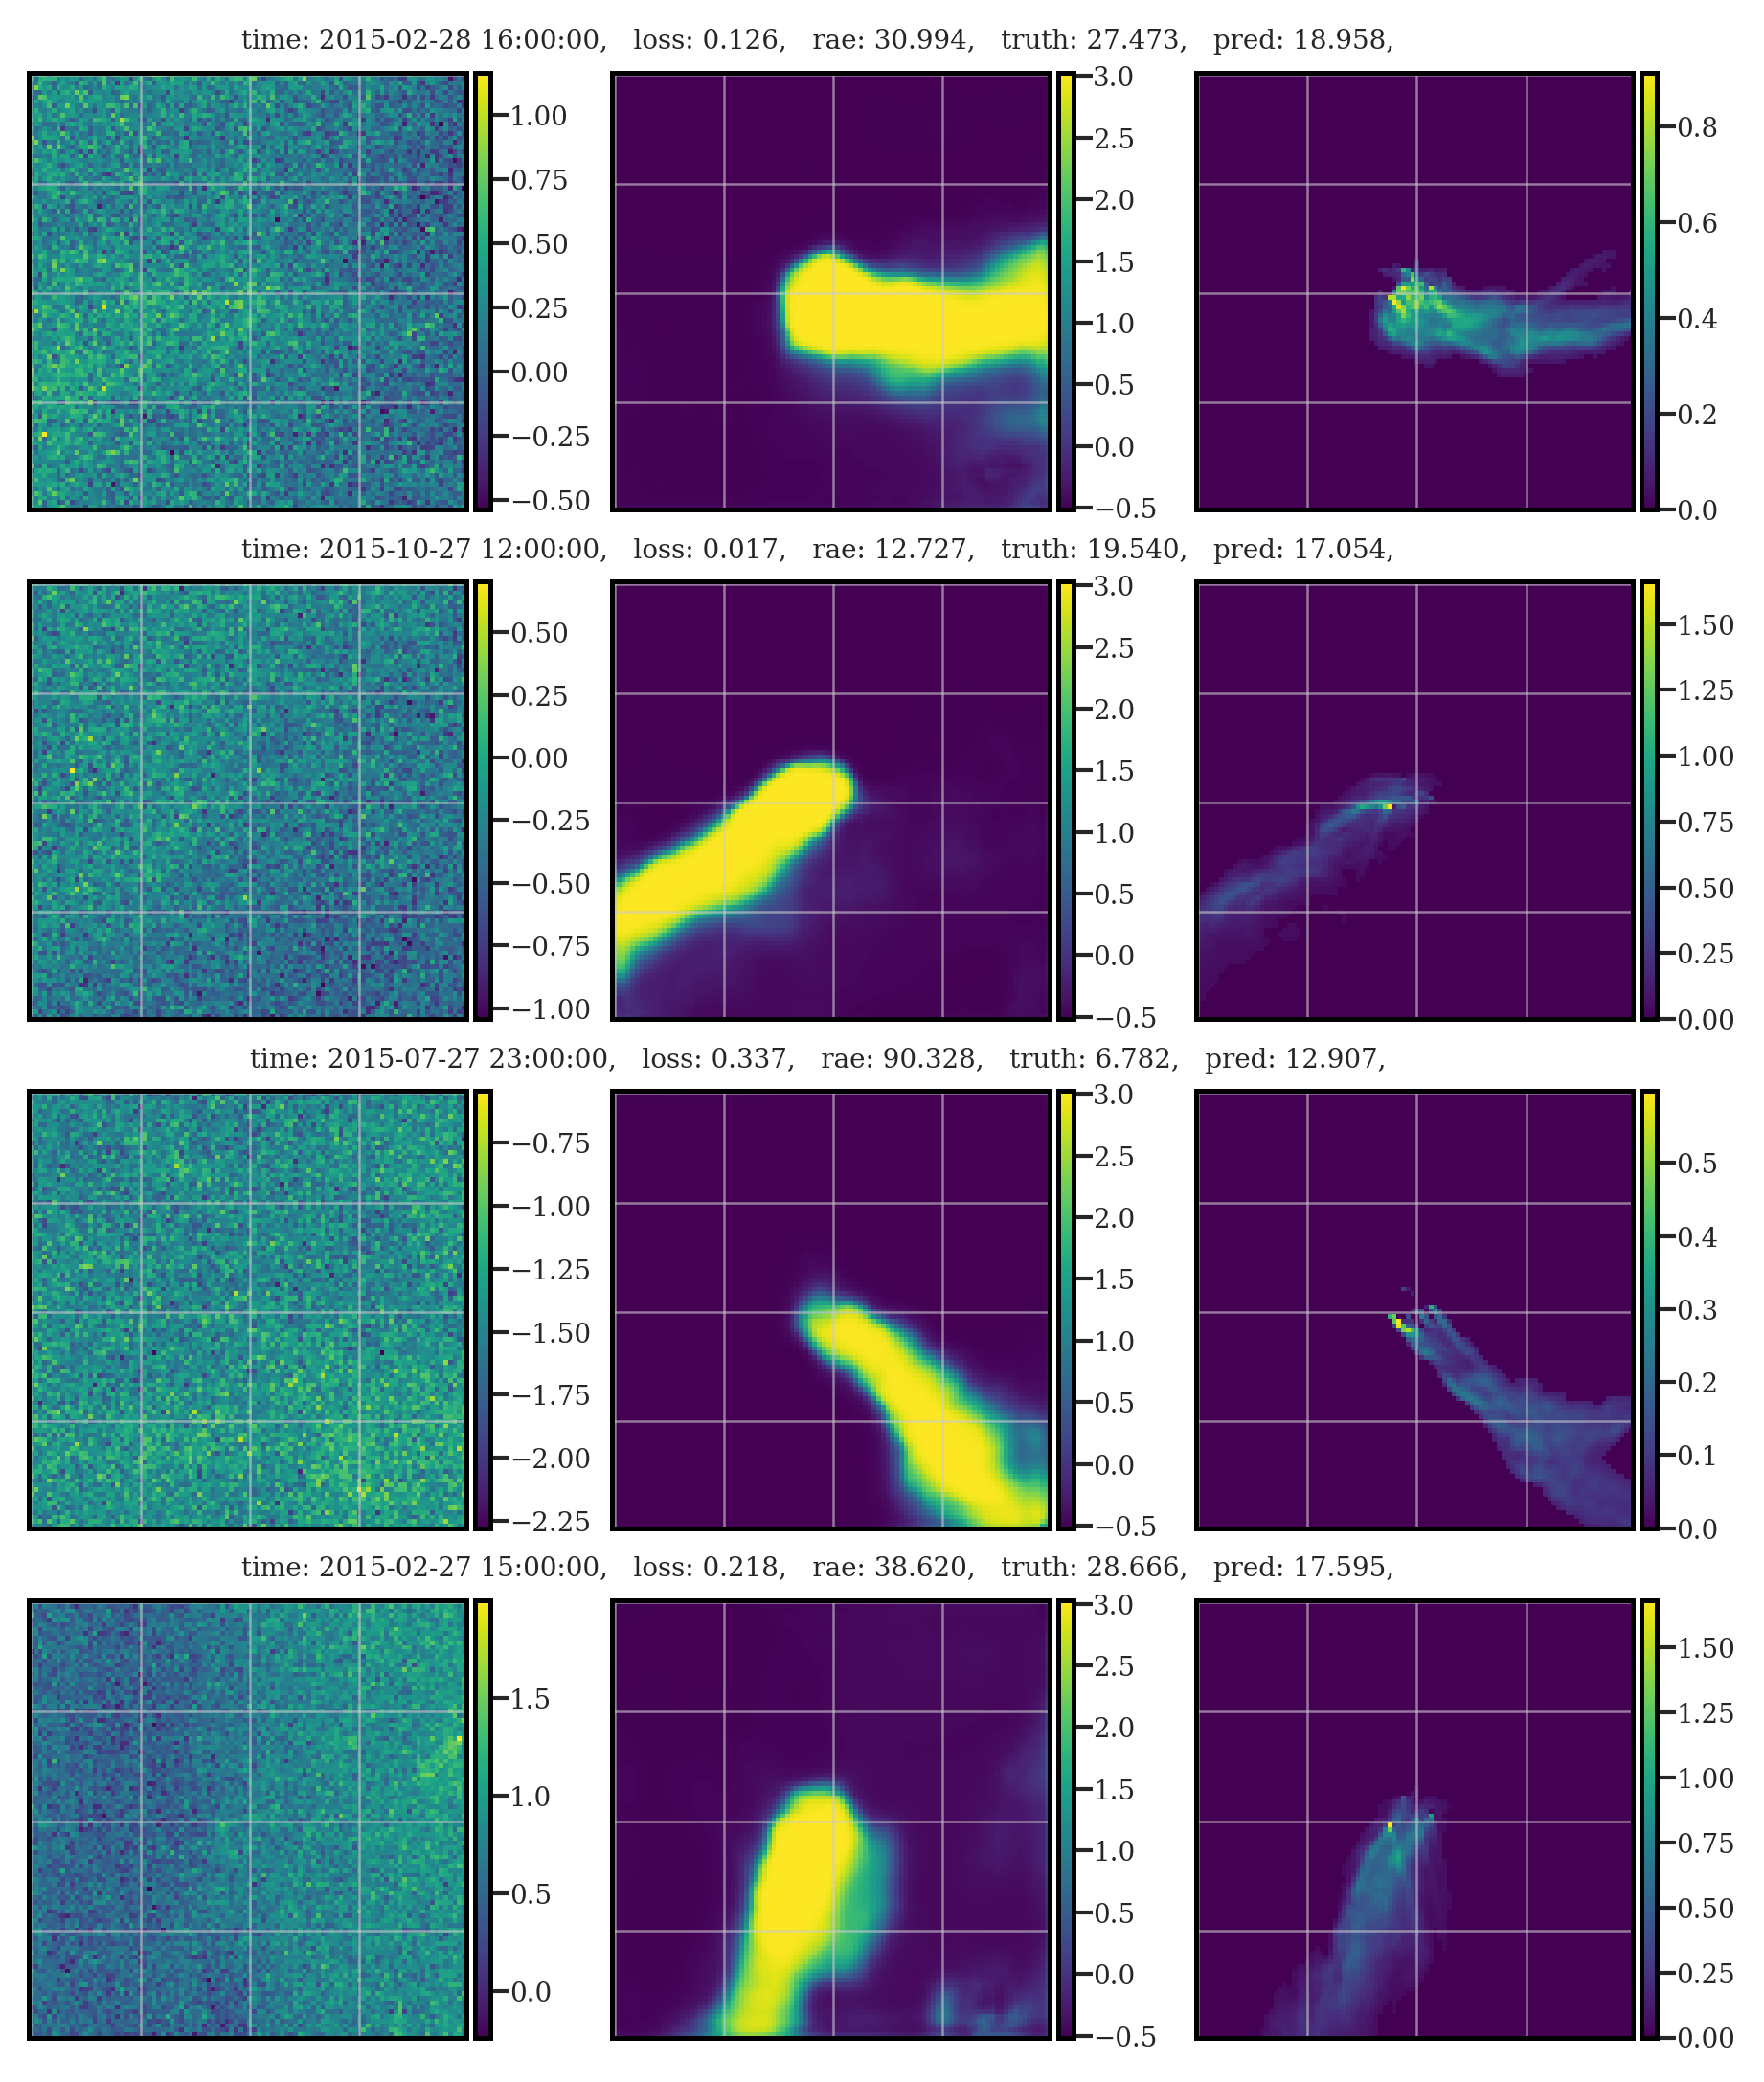

In [101]:
N_rows=4
N_cols=3
matplotlib_functions.setMatplotlibParam()
plt.viridis()
axs = matplotlib_functions.set_figure_axs(N_rows, N_cols, wratio=0.35, hratio=0.75, pad_w_ext_left=0.25, 
                                          pad_w_ext_right=0.25, pad_w_int=0.001, pad_h_ext=0.2, pad_h_int=0.25)

ims = [None]*(N_rows*N_cols)
caxs = [None]*(N_rows*N_cols)
cbars = [None]*(N_rows*N_cols)

for ax in axs:
    ax.set_xticks([0,24,48,72,96])
    ax.set_yticks([0,24,48,72,96])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

for i, idx in enumerate([idx0, idx1, idx2, idx3]): 
    i_ax = 0 + i*3
    ims[i_ax] = axs[i_ax].imshow(np.squeeze(data.x.valid[idx,:,:,0]))
    caxs[i_ax] = axs[i_ax].inset_axes((1.02, 0, 0.035, 1))
    cbars[i_ax] = plt.colorbar(ims[i_ax], caxs[i_ax], orientation="vertical")

    i_ax = 1 + i*3
    ims[i_ax] = axs[i_ax].imshow(np.squeeze(data.x.valid[idx,:,:,1]))
    caxs[i_ax] = axs[i_ax].inset_axes((1.02, 0, 0.035, 1))
    cbars[i_ax] = plt.colorbar(ims[i_ax], caxs[i_ax], orientation="vertical")

    i_ax = 2 + i*3
    ims[i_ax] = axs[i_ax].imshow(np.squeeze(ds_valid.plume[idx]))
    caxs[i_ax] = axs[i_ax].inset_axes((1.02, 0, 0.035, 1))
    cbars[i_ax] = plt.colorbar(ims[i_ax], caxs[i_ax], orientation="vertical")

for i, idx in enumerate([idx0, idx1, idx2, idx3]):
    axs[1+i*3].set_title(
        f"time: {pd.Timestamp(ds_valid.time[idx].values)},   "
        f"loss: {all_loss_valid[idx].numpy():.3f},   "
        f"rae: {all_rae_valid[idx].numpy():.3f},   "
        f"truth: {y_valid[idx].numpy()[0]:.3f},   "
        f"pred: {pred_valid[idx].numpy()[0]:.3f},   "
    )

In [143]:
df_rae = pd.DataFrame({'loss': all_rae_valid,
                      'method': ["CNN"]*len(all_rae_valid) })
df_rae = pd.concat([df_rae, pd.DataFrame({'loss': all_rae_baseline,
                       'method': ["mean"]*len(all_rae_valid) })], ignore_index=True)

<Figure size 1800x1200 with 0 Axes>

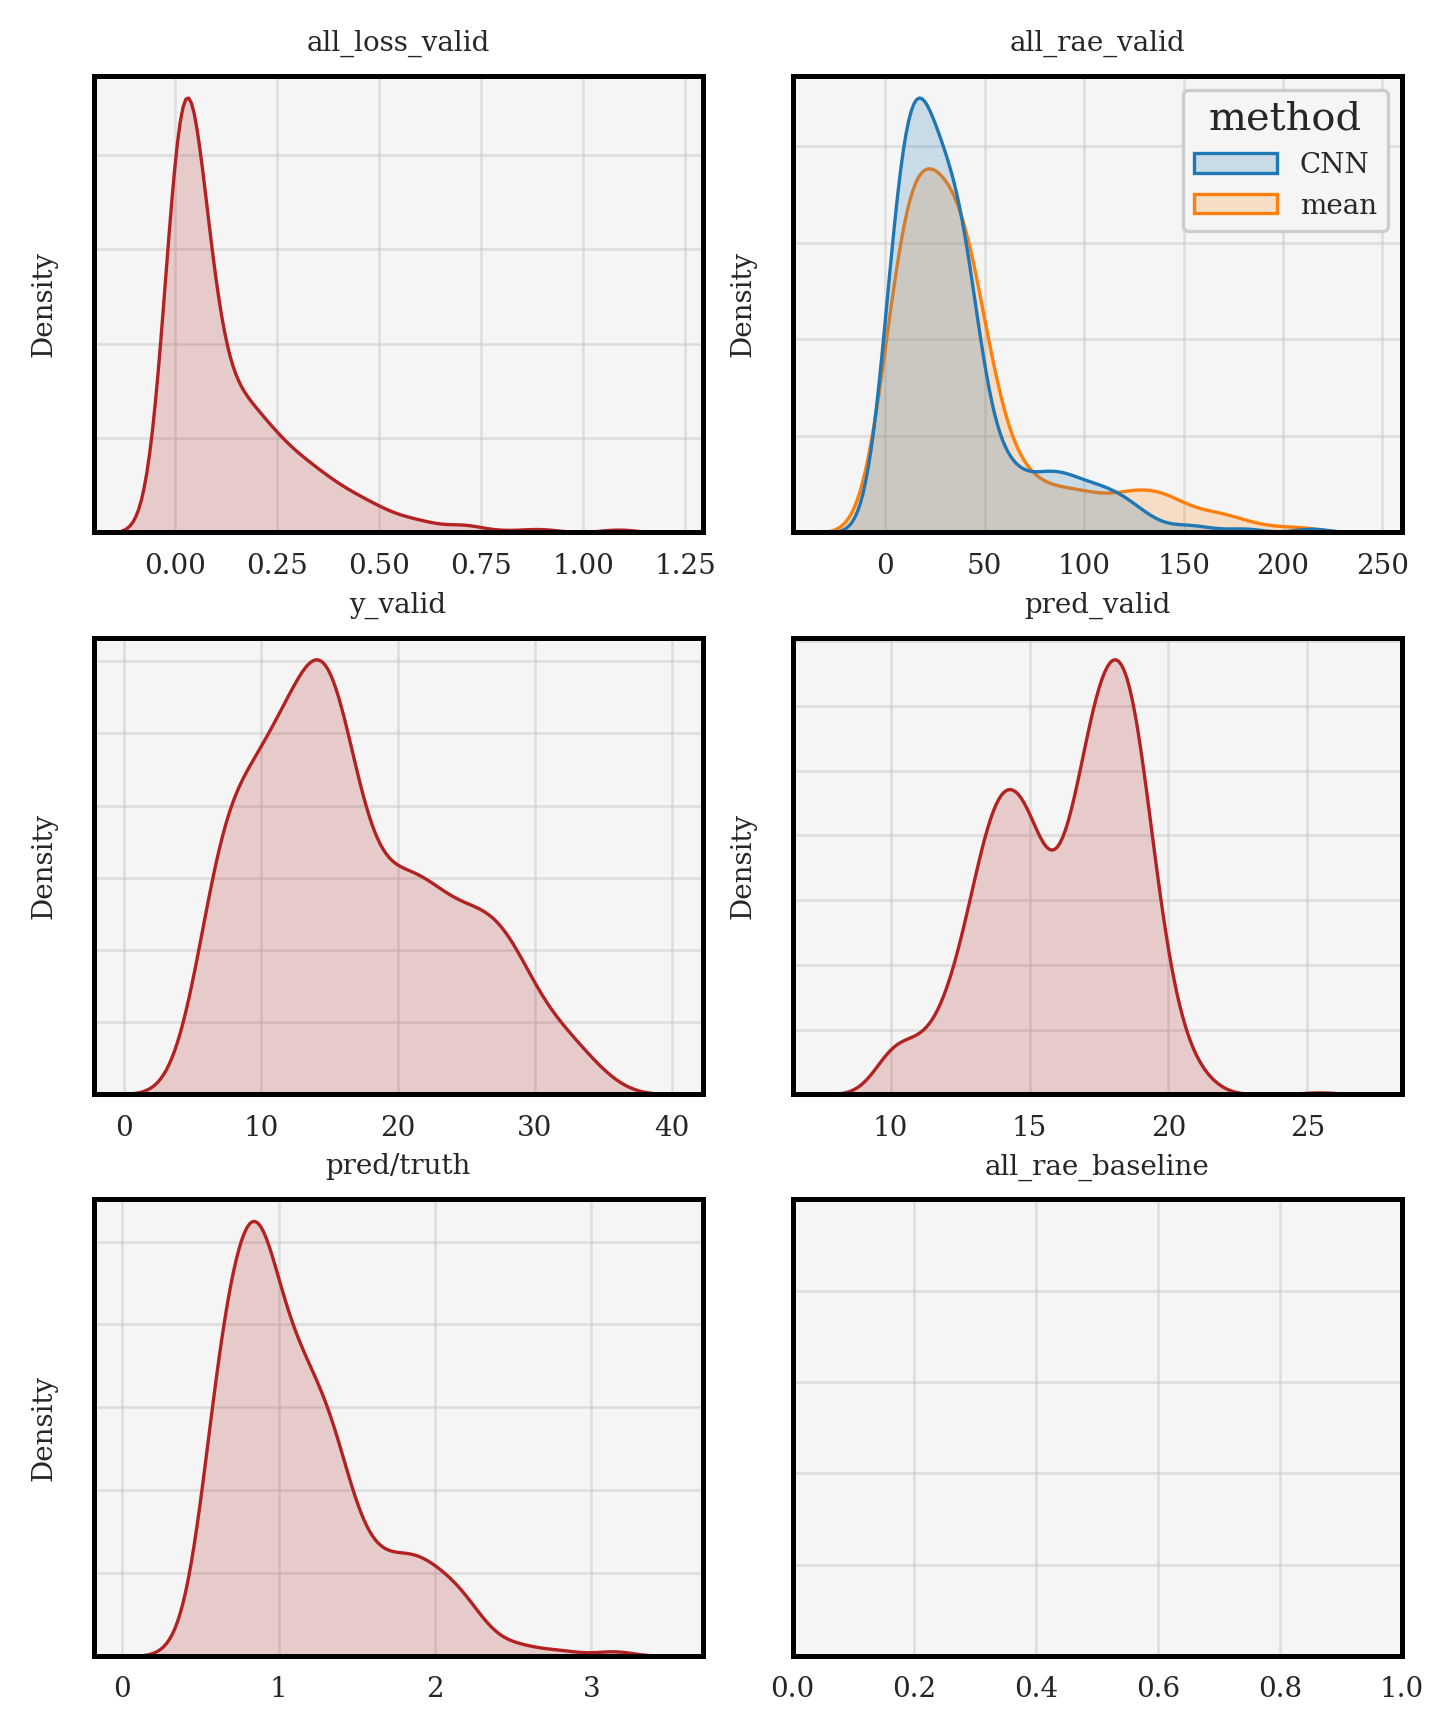

In [155]:
N_rows=3
N_cols=2
matplotlib_functions.setMatplotlibParam()
plt.viridis()
axs = matplotlib_functions.set_figure_axs(N_rows, N_cols, wratio=0.35, hratio=0.75, pad_w_ext_left=0.25, 
                                          pad_w_ext_right=0.25, pad_w_int=0.3, pad_h_ext=0.2, pad_h_int=0.35)

sns.kdeplot(all_loss_valid.numpy(), color="firebrick", fill=True, alpha=0.2, ax=axs[0])
sns.kdeplot(data=df_rae, x="loss", common_norm=True, hue="method", color="firebrick", fill=True, alpha=0.2, ax=axs[1])
sns.kdeplot(np.squeeze(y_valid.numpy()), color="firebrick", fill=True, alpha=0.2, ax=axs[2])
sns.kdeplot(np.squeeze(pred_valid.numpy()), color="firebrick", fill=True, alpha=0.2, ax=axs[3])
sns.kdeplot(np.squeeze(pred_valid.numpy()/y_valid.numpy()), color="firebrick", fill=True, alpha=0.2, ax=axs[4])

titles = ["all_loss_valid", "all_rae_valid", "y_valid", "pred_valid", "pred/truth", "all_rae_baseline"]

for i_ax, ax in enumerate(axs):
    ax.set_yticklabels([])
    ax.set_xlabel("")
    ax.set_title(titles[i_ax])

In [149]:
ratio = pred_valid.numpy()/y_valid.numpy()
print(np.median(ratio))

1.0167956


### Inversion losses with respect to characteristics of the image-plume

In [16]:
df = pd.DataFrame({'loss': all_loss_valid,
                   'origin': ds_valid.folder.values.astype(str),
                   'time': ds_valid.v_hour.values,
                   'emiss': ds_valid.emiss.values[:,0]
                  })

In [47]:
df["emiss"] = pd.qcut(df["emiss"], q=4, precision=2)

In [48]:
df

,loss,origin,time,emiss
0,0.050977,smart_pLip_nBLip,2,"(5.45, 15.47]"
1,0.352189,lsce_pPGI_nBBO,21,"(20.44, 29.9]"
2,0.000477,smart_pBox_nBBox,14,"(15.47, 20.44]"
3,0.138708,lsce_pPGI_nBBO,20,"(29.9, 75.82]"
4,0.000193,smart_pLip_nBLip,17,"(5.45, 15.47]"
...,...,...,...,...
6044,0.007022,smart_pBox_nBBox,4,"(15.47, 20.44]"
6045,0.031270,smart_pLip_nBLip,0,"(15.47, 20.44]"
6046,0.000029,smart_pJan_nBJan,11,"(29.9, 75.82]"
6047,0.000964,smart_pLip_nBLip,6,"(5.45, 15.47]"


In [49]:
df["origin"] = np.where(df["origin"].values == "smart_pBox_nBBox", "Boxberg (PP)", df["origin"].values)
df["origin"] = np.where(df["origin"].values == "smart_pLip_nBLip", "Lippendorf (PP)", df["origin"].values)
df["origin"] = np.where(df["origin"].values == "smart_pJan_nBJan", "Janschwälde (PP)", df["origin"].values)
df["origin"] = np.where(df["origin"].values == "lsce_pPG_nBBO", "Grand Paris", df["origin"].values)
df["origin"] = np.where(df["origin"].values == "lsce_pPGI_nBBO", "Grand Paris + IDF", df["origin"].values)

[None, None]

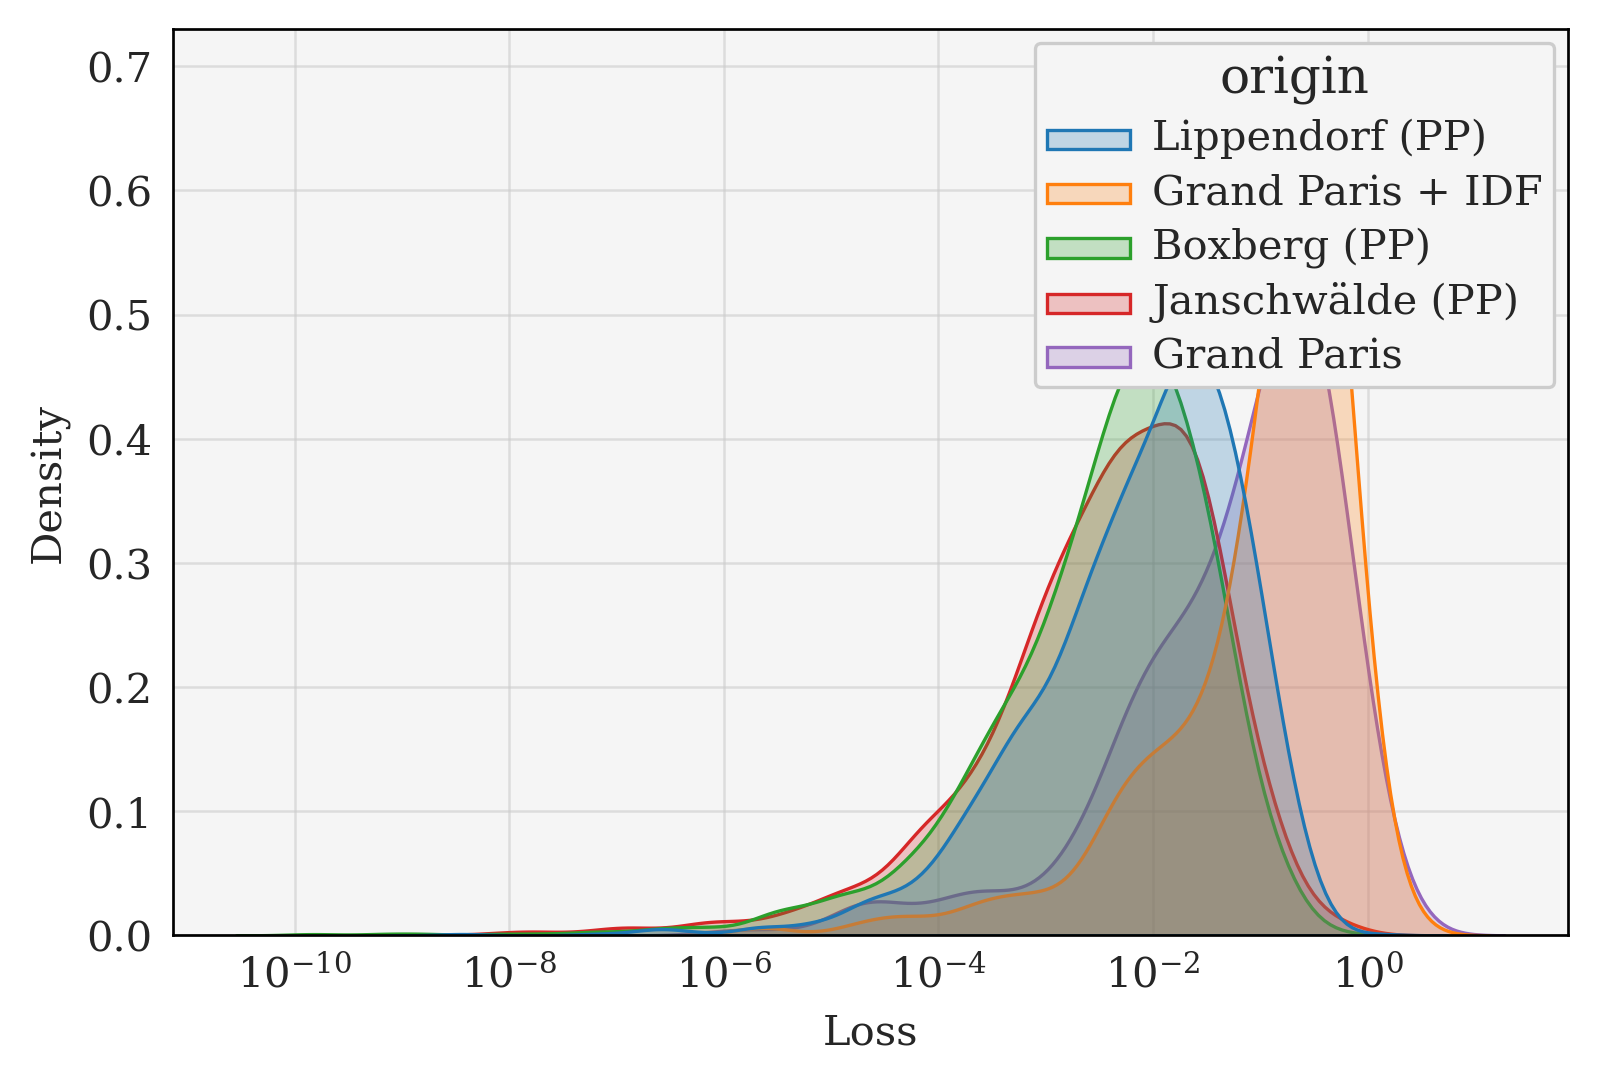

In [54]:
ax = sns.kdeplot(
    data=df,
    x="loss",
    hue="origin",
    log_scale=True,
    common_norm=False,
    fill=True
)
plt.xlabel("Loss", size=10)
plt.ylabel("Density", size=10)
plt.xticks(size=10)
plt.yticks(size=10)
plt.setp(ax.get_legend().get_texts(), fontsize='10')
plt.setp(ax.get_legend().get_title(), fontsize='12')
#plt.savefig(os.path.join(dir_fig, f"paper_w{weights_ds}_ds{data.name_dataset}_hist_origin.png"))

### Very bad evaluations

In [55]:
n_max_val = int(0.01*len(all_loss_valid))
worst_eval_indices = np.argpartition(all_loss_valid, -n_max_val)[-n_max_val:]

In [57]:
idx_worst = np.random.choice(worst_eval_indices)
print(model.compute_loss(y=y_valid[idx_worst:idx_worst+1], y_pred=pred_valid[idx_worst:idx_worst+1]).numpy())

0.9809934


0.84148914
origin: lsce_pPG_nBBO
time: 2018-03-17T05:00:00.000000000
emiss: [10.39492    8.527399   8.173362   8.220841   8.3150425  9.055608 ]
truth: 10.39492
pred: 27.516844


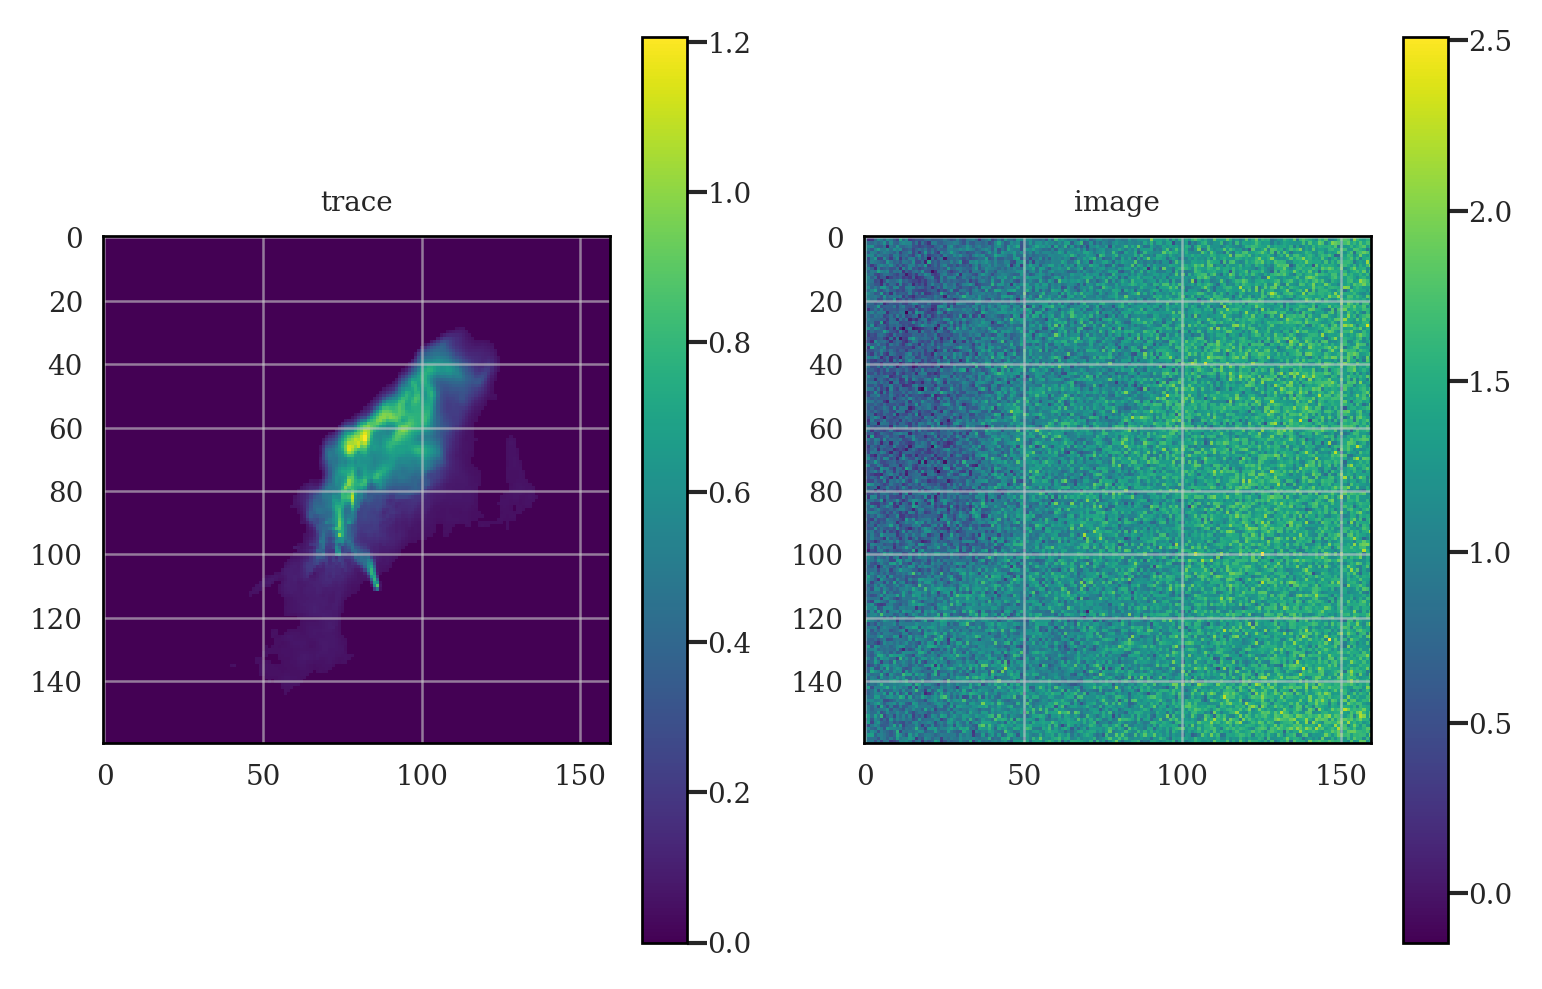

In [73]:
idx_worst = np.random.choice(worst_eval_indices)
print(model.compute_loss(y=y_valid[idx_worst:idx_worst+1], y_pred=pred_valid[idx_worst:idx_worst+1]).numpy())
ds_idx = ds_valid.isel(idx_img=idx_worst)
print("origin:", ds_idx.folder.values)
print("time:", ds_idx.time.values)
print("emiss:", ds_idx.emiss.values)

plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(data.y.trace_valid[idx_worst]))
plt.colorbar()
plt.title("trace")

plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(data.x.valid[0][idx_worst,:,:,0]))
plt.colorbar()
plt.title("image")

print("truth:", np.squeeze(data.y.valid[idx_worst]))
print("pred:", np.squeeze(model(tf.expand_dims(data.x.valid[0][idx_worst], 0))[0]))

### Histogram perf.

In [47]:
config_weights = TreeConfigParser()
config_weights.readfiles(os.path.join(dir_res, weights, "config.cfg"))
weights_ds = config_weights.get("data.directory.name")
dir_fig = os.path.join("eval/fig/reg", weights_ds)
if not os.path.exists(dir_fig):
    os.makedirs(dir_fig)

In [50]:
df = pd.DataFrame({'y_true': np.squeeze(data.y.valid), 'y_pred': np.squeeze(pred_valid.numpy()), 
                   'pred_truth': (np.squeeze(pred_valid.numpy())-np.squeeze(data.y.valid))/np.squeeze(data.y.valid)})
df["True emissions (Mt/yr)"] = pd.qcut(df["y_true"], q=4, precision=2)

In [53]:
ax = sns.histplot(
    data=df,
    x="pred_truth",
    hue="True emissions (Mt/yr)",
    log_scale=False,
    element="step",
    stat="density",
    common_norm=False,
    bins=100,
)
plt.xlabel("(Predicted - True emissions) / (True emissions)", size=12)
plt.ylabel("Density", size=12)
plt.xticks(size=11)
plt.yticks(size=11)
plt.xlim(-1,2)
plt.setp(ax.get_legend().get_texts(), fontsize='11')
plt.setp(ax.get_legend().get_title(), fontsize='13')
path_save = os.path.join(dir_fig, f"paper_reg_w{weights}_ds{data.name_dataset}_hist_emiss.png")
plt.savefig(path_save, transparent=True)

## Save for paper

In [113]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [20]:
config_weights = TreeConfigParser()
config_weights.readfiles(os.path.join(dir_res, weights, "config.cfg"))
weights_ds = config_weights.get("data.directory.name")
dir_fig = os.path.join("eval/fig/reg", weights_ds)
if not os.path.exists(dir_fig):
    os.makedirs(dir_fig)

In [22]:
number_bins         = 100

opacity             = 0.2
choice_kde          = True
choice_hist_sns     = True
choice_rug_sns      = False
choice_kde_kws      = {'shade': False, 'linewidth': 0.5}
hist_kws            = {'alpha': 0.2, 'density' : True}

sns.set_context('paper')
sns.set_style('whitegrid')
plt.viridis()

plt.rc('lines',         linewidth           = 0.5)
plt.rc('lines',         markeredgewidth     = 0.5)
plt.rc('lines',         markersize          = 4)
plt.rc('figure',        dpi                 = 300)
plt.rc('text',          usetex              = False )
plt.rc('font',          family              = 'serif')
plt.rc('savefig',       facecolor           = 'white')
plt.rc('axes',          linewidth           = 0.65)
plt.rc('axes',          edgecolor           = 'k')
plt.rc('axes',          facecolor           = [0.96, 0.96, 0.96])
plt.rc('axes',          labelsize           = 'x-small')
plt.rc('axes',          titlesize           = 'x-small')
plt.rc('legend',        fontsize            = 'x-small')
plt.rc('legend',        frameon             = True)
plt.rc('legend',        framealpha          = 1)
plt.rc('legend',        handlelength        = 3)
plt.rc('legend',        numpoints           = 3)
plt.rc('legend',        markerscale         = 1)
plt.rc('xtick',         labelsize           = 'x-small')
plt.rc('ytick',         labelsize           = 'x-small')
plt.rc('xtick.major',   pad                 = 0)
plt.rc('ytick.major',   pad                 = 0)
plt.rc('grid', linewidth = 0.6)
plt.rc('grid', alpha = 0.6)

wratio=0.35
hratio=0.75
pad_w_ext=0.25
pad_w_int=0.001
pad_h_ext=0.2
pad_h_int=0.1
# linewidth
linewidth   = 5.80910486111 # [inch]
# (w, h) for the ax
ax_w        = wratio * linewidth
ax_h        = hratio * ax_w

# (w, h) for the figure
fig_w       = pad_w_ext + ax_w + pad_w_int + ax_w + pad_w_ext
fig_h       = pad_h_ext + ax_h + pad_h_int + ax_h + pad_h_ext

# (x, y) for the ax 
ax1_x       = pad_w_ext / fig_w
ax2_x       = ( pad_w_ext + ax_w + pad_w_int ) / fig_w
ax1_y       = ( pad_h_ext + ax_h + pad_h_int ) / fig_h
ax2_y       = pad_h_ext  / fig_h
ax_dx       = ax_w / fig_w
ax_dy       = ax_h / fig_h

In [60]:
idx0 = 621
print(model.compute_loss(y=y_valid[idx0:idx0+1], y_pred=pred_valid[idx0:idx0+1]).numpy())
print(model.compute_loss(y=y_valid[idx1:idx1+1], y_pred=pred_valid[idx1:idx1+1]).numpy())

idx1 = 571
ds_idx0 = ds_valid.isel(idx_img=[idx0])
ds_idx1 = ds_valid.isel(idx_img=[idx1])

0.0033356943
0.031233296


In [101]:
idx0 = int(np.random.uniform(0,data.y.valid.shape[0]*0.2))
print(model.compute_loss(y=y_valid[idx0:idx0+1], y_pred=pred_valid[idx0:idx0+1]).numpy())
ds_idx0 = ds_valid.isel(idx_img=[idx0])

0.043873798


In [81]:
idx1 = int(np.random.uniform(0,data.y.valid.shape[0]*0.2))
print(model.compute_loss(y=y_valid[idx1:idx1+1], y_pred=pred_valid[idx1:idx1+1]).numpy())
ds_idx1 = ds_valid.isel(idx_img=[idx1])

0.0045376164


In [28]:
folder_to_origin = {"smart_pBox_nBBox": "Boxberg (PP)",
                    "smart_pLip_nBLip": "Lippendorf (PP)",
                    "smart_pJan_nBJan": "Janschwälde (PP)",
                    "lsce_pPG_nBBO": "Grand Paris",
                    "lsce_pPGI_nBBO": "Grand Paris + IDF"}

In [29]:
ds_valid

<xarray.Dataset>
Dimensions:         (idx_img: 6049, dir_crop: 4, y: 160, x: 160, hour_prec: 6,
                     hour: 24)
Coordinates:
  * idx_img         (idx_img) int32 21940 30000 5558 28271 ... 16164 21272 20306
  * y               (y) int32 0 1 2 3 4 5 6 7 ... 153 154 155 156 157 158 159
  * x               (x) int32 0 1 2 3 4 5 6 7 ... 153 154 155 156 157 158 159
Dimensions without coordinates: dir_crop, hour_prec, hour
Data variables:
    folder          (idx_img) object smart_pLip_nBLip ... smart_pLip_nBLip
    ppresence       (idx_img) bool True True True True ... True True True True
    index_crop      (idx_img) bool False False False False ... False False False
    time            (idx_img) datetime64[ns] 2015-07-18T02:00:00 ... 2015-05-11
    shape_cropping  (idx_img, dir_crop) int32 0 160 0 160 0 ... 160 0 160 0 160
    emiss           (idx_img, hour_prec) float32 8.39 8.39 9.206 ... 11.22 11.22
    pixels_plume    (idx_img, y, x) float32 ...
    trace           (idx_img, y, x) float32 ...
    v_hour          (idx_img) int64 2 21 14 20 17 16 22 20 ... 16 7 4 0 11 6 0
    v_oneHotHour    (idx_img, hour) int32 ...
    xco2            (idx_img, y, x) float32 403.0 403.0 403.0 ... 405.5 405.5
Attributes:
    description:  Anthropogenic XCO2 plume related data
    N_p_crop:     0
    N_n_crop:     0
    thresh_type:  pure
    thresh_val:   0.05
    N_img:        30243

In [118]:
# create figure and ax
figure      = plt.figure(figsize=(fig_w, fig_h))
ax1         = figure.add_axes([ax1_x, ax1_y, ax_dx, ax_dy])
ax3         = figure.add_axes([ax1_x, ax2_y, ax_dx, ax_dy])

ax1.set_ylabel("Input xco2 field")
im1 = ax1.imshow(scaler.inverse_transform(np.squeeze(data.x.valid[0][idx0,:,:,0])))
ax1.set_xticklabels([])
cax1 = ax1.inset_axes((1.02, 0, 0.035, 1))
cbar1 = plt.colorbar(im1, cax1, orientation="vertical")
cbar1.ax.tick_params(labelsize="8")



ax3.set_ylabel("Input xco2 field")
im3 = ax3.imshow(scaler.inverse_transform(np.squeeze(data.x.valid[0][idx1,:,:,0])))
cax3 = ax3.inset_axes((1.02, 0, 0.035, 1))
cbar3 = plt.colorbar(im3, cax3, orientation="vertical")
cbar3.ax.tick_params(labelsize="8")

text_idx0 = (f'Plume origin: {folder_to_origin[ds_idx0.folder.astype(str).values[0]]} \n'
f'Satellite time: {ds_idx0.v_hour.values[0]:02d}:00 UTC \n'
f'True emissions: {data.y.valid[idx0,0]: .2f} Mt yr-1 \n'             
f'Estimated emissions: {model(tf.expand_dims(data.x.valid[0][idx0], 0))[0].numpy()[0]: .2f} Mt yr-1 \n'
f'MSLE error: {all_loss_valid[idx0].numpy():.3f} \n' 
f'Relative error: {(pred_valid[idx0].numpy()[0]-data.y.valid[idx0][0])/data.y.valid[idx0][0]:.3f}')

plt.text(214,-45,text_idx0, fontsize=8)

text_idx1 = (f'Plume origin: {folder_to_origin[ds_idx1.folder.astype(str).values[0]]}\n'
f'Satellite time: {ds_idx1.v_hour.values[0]:02d}:00 UTC \n'
f'True emissions: {data.y.valid[idx1,0]: .2f} Mt yr-1 \n'
f'Estimated emissions: {model(tf.expand_dims(data.x.valid[0][idx1], 0))[0].numpy()[0]: .2f} Mt yr-1 \n'
f'MSLE error: {all_loss_valid[idx1].numpy():.3f} \n' 
f'Relative error: {(pred_valid[idx1].numpy()[0]-data.y.valid[idx1][0])/data.y.valid[idx1][0]:.3f}')

plt.text(214,100,text_idx1, fontsize=8)
plt.savefig(os.path.join(dir_fig, f"paper_reg_w{weights_ds}_ds{data.name_dataset}_i{idx0}_i{idx1}.png"))
print(os.path.join(dir_fig, f"paper_reg_w{weights_ds}_ds{data.name_dataset}_i{idx0}_i{idx1}.png"))

eval/fig/reg/LS_pPGIPW/paper_reg_wLS_pPGIPW_dsLS_pPGIPW_i877_i855.png


0.21590909090909072

In [76]:
losses = all_loss_valid.numpy()

In [77]:
np.sum(np.abs(losses)<0.05)/np.shape(losses)[0]

0.7964952884774343

In [87]:
all_rerr_valid = (np.squeeze(pred_valid.numpy())-np.squeeze(data.y.valid))/np.squeeze(data.y.valid)

In [103]:
np.sum(np.abs(all_rerr_valid)<0.2)/np.shape(all_rerr_valid)[0]

0.7498760125640602

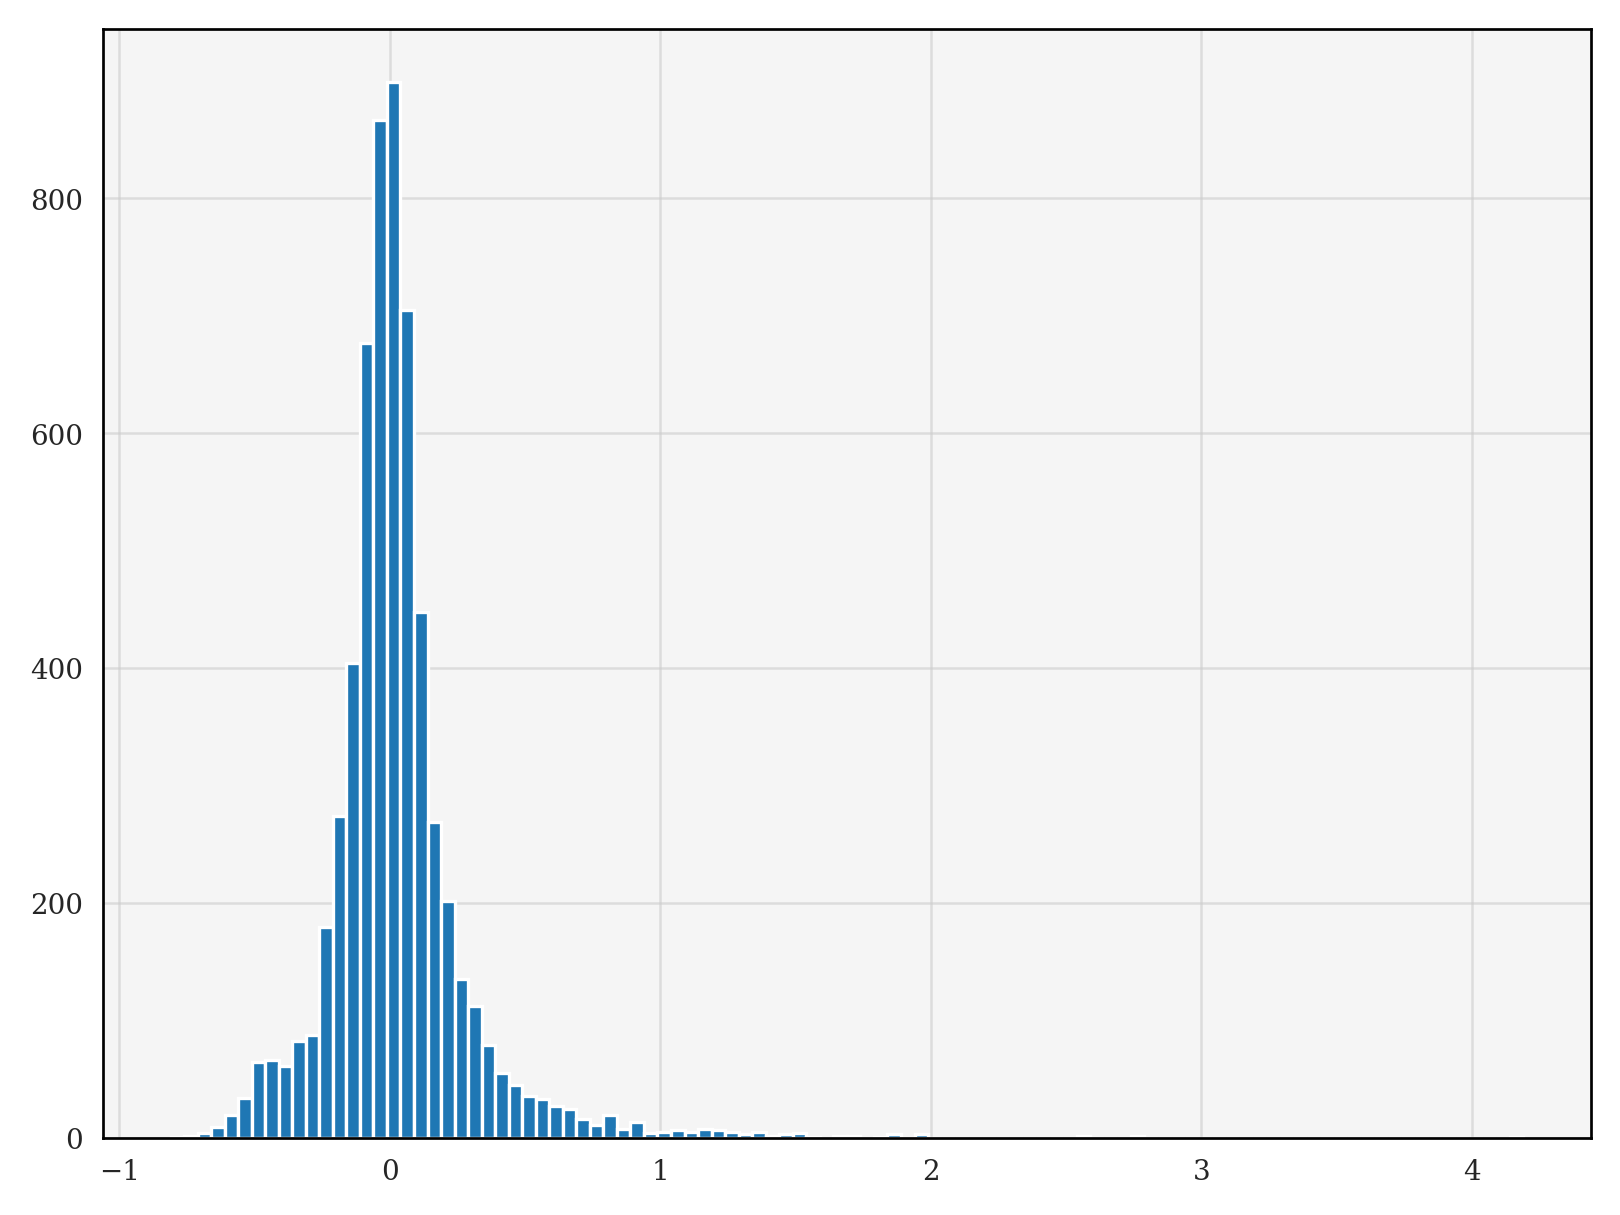

In [88]:
plt.hist(all_rerr_valid, bins=100); plt.show()